# RecSys

>[!NOTE]
>
>I have tested some model some key points are:
>1. no FE was done.
>2. just fine tune some model and choose those model that perform good on the dataset.
>3. The rsme will be higher ( The data is mostly random generated so based on that its hard to actually says the model perform well -- the random thing made the models hard to learn)

## Imports

In [1]:
import pandas as pd
import numpy as np
from score import score
from rec_utils import split_the_data
import ast
import warnings
warnings.filterwarnings('ignore')

# surprise
from surprise import SVDpp, BaselineOnly
from surprise.model_selection import train_test_split as sur_tts
from surprise import Dataset, Reader, accuracy

# torch
import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

# plt
import matplotlib.pyplot as plt

In [2]:
user_data = pd.read_csv("../Course_Scraper/assets/augumented_data/augmented_user_rating.csv")

In [3]:
course = pd.read_csv("../Course_Scraper/assets/formated_data/formated_course.csv")[['title_index', 'skills']]
courses = pd.read_csv("../Course_Scraper/assets/formated_data/formated_courses.csv")[['title_index', 'skills']]

course.dropna(subset='skills', inplace=True)
courses.dropna(subset='skills', inplace=True)

--- get total skills that are unique so i can build something ---

In [4]:
def convert_to_list(data):
    """
    Single list or simply for row
    """
    return ast.literal_eval(data)

def convert_series_to_list(data: pd, warn=False, add_nan=True):
    """
    Here data is the pd.Series
    """
    return [skill for sublist in data for skill in sublist]

def get_unique_skills(course, courses):
    l1 = convert_series_to_list(course['skills'])
    l2 = convert_series_to_list(courses['skills'])
    l = l1 + l2
    return set(l)

--- building genres (one hot encoding) ---

In [5]:
course['skills'] = course['skills'].apply(lambda x: convert_to_list(x))
courses['skills'] = courses['skills'].apply(lambda x: convert_to_list(x))

all_skills = list(get_unique_skills(course, courses))
print(f'Total skills are: {len(all_skills)}')

Total skills are: 1588


In [6]:
skills = pd.concat([course.explode('skills'), courses.explode('skills')], ignore_index=True)

In [7]:
skill_onehot = pd.get_dummies(skills).astype(int).groupby('title_index').max().reset_index()

In [8]:
user_data = user_data.merge(skill_onehot, on='title_index', how='left').fillna(0)

In [9]:
user_data.head()

,title_index,user_index,rating,skills_3D Assets,skills_A/B Testing,skills_AI Personalization,skills_AI Product Strategy,skills_AWS CloudFormation,skills_AWS Identity and Access Management (IAM),skills_AWS Kinesis,...,skills_Writing,skills_Writing and Editing,skills_X-Ray Computed Tomography,skills_and Compliance,skills_and Development,skills_and Facility Services,skills_and Logistics,skills_and Social Studies,skills_and Technical Instruments,skills_iOS Development
0,241,4637,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,241,9238,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,241,7214,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,241,4050,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,241,9878,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


--- mapping just in case in need it ---

In [10]:
user_mapping = {
    k: x for x, k in enumerate(user_data['user_index'].unique())
}

# so we get a consistent titles
title_mapping = {
    k: x for x, k in enumerate(user_data['title_index'].unique())
}

---

## CONFIGS

In [11]:
# some configs
class CONFIG:
    seed = 67
    BATCH_SIZE = 4096
    EPOCH = 100
    
cfg = CONFIG()

In [12]:
torch.manual_seed(cfg.seed)

---

## Surpise -- BaselineOnly

In [13]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(user_data[['title_index', 'user_index', 'rating']], reader)
train, test = sur_tts(data, test_size=0.2, shuffle=True)

bsl_options = {
    "n_epochs": 20,
    "method": "sgd",
    "learning_rate": 0.001,
    "seed": cfg.seed
}
algo = BaselineOnly(bsl_options=bsl_options)
algo.fit(train)
predictions = algo.test(test)
print("\nSocre on Test: ", accuracy.rmse(predictions, verbose=True))

Estimating biases using sgd...
RMSE: 1.6104

Socre on Test:  1.6104089092494782


---

## NN

In [14]:
user_data['user_index'] = user_data['user_index'].map(user_mapping)
user_data['title_index'] = user_data['title_index'].map(title_mapping)

# data, test = split_the_data(user_data)
data, test = split_the_data(user_data[['title_index', 'user_index', 'rating']])
train, val = split_the_data(data)

X_train = train.drop('rating', axis=1)
X_val = val.drop('rating', axis=1)

y_train = train['rating']
y_val = val['rating']

In [15]:
total_users = len(user_mapping)
total_titles = len(title_mapping)

print(f'Total users: {total_users}')
print(f'Total titles: {total_titles}')

Total users: 10632
Total titles: 548


In [16]:
class ResidualBlock(nn.Module):
    def __init__(self, features):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(features, features)
        self.bn1 = nn.BatchNorm1d(features)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(features, features)
        self.bn2 = nn.BatchNorm1d(features)

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.fc1(x)))
        out = self.bn2(self.fc2(out))
        out += identity 
        out = self.relu(out)
        return out

In [29]:
# thought of adding attention in it, but though...................meh...just made it run
class RecSys(nn.Module):
    def __init__(self, total_users, total_tiltes, user_emb_dim: int = 32, title_emb_dim: int = 32): # skill_emb_dim=32,  total_skills
        super(RecSys, self).__init__()
        self.usr_emb = nn.Embedding(total_users, user_emb_dim)
        self.title_emb = nn.Embedding(total_titles, title_emb_dim)
        # self.skill_emb = nn.Embedding(total_skills, skill_emb_dim)
        self.fc1 = nn.Linear((user_emb_dim + title_emb_dim), 128)
        # self.skill_proj = nn.Linear(total_skills, skill_emb_dim, bias=False)
        # self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(0.2)
        self.res_block1 = ResidualBlock(128)
        
        self.fc2 = nn.Linear(128, 64)
        self.res_block2 = ResidualBlock(64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, x):
        user = x[:, 1].long()
        title = x[:, 0].long()
        # skill = x[:, 2:].float()

        u = self.usr_emb(user)
        t = self.title_emb(title)
        # s = self.skill_proj(skill.float())
        
        # x = torch.concat([u, t, s], dim=1)
        x = torch.concat([u, t], dim=1)
        x = self.fc1(x)
        x = self.res_block1(x)
        # x = self.dropout(x)
        x = self.fc2(x)
        x = self.res_block2(x)
        # x = self.dropout(x)
        x = self.fc3(x)
        # x = self.softmax(x)
        return x

In [30]:
# model = RecSys(total_users=total_users, total_tiltes=total_titles, total_skills=len(all_skills)).to('cuda')
model = RecSys(total_users=total_users, total_tiltes=total_titles).to('cuda')
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-2, momentum=0.7)

In [31]:
tensor_Xtr = torch.tensor(X_train.to_numpy(), dtype=torch.float)  
tensor_Xva = torch.tensor(X_val.to_numpy(), dtype=torch.float)    
tensor_ytr = torch.tensor(y_train.to_numpy(), dtype=torch.float)  
tensor_yva = torch.tensor(y_val.to_numpy(), dtype=torch.float)    

train_dataset = TensorDataset(tensor_Xtr, tensor_ytr)
val_dataset   = TensorDataset(tensor_Xva, tensor_yva)

train_loader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [32]:
train_losses = []
val_losses = []

for epoch in range(cfg.EPOCH):
    model.train()
    loss_ = 0

    for x_, y_ in train_loader:
        x_ = x_.to('cuda', non_blocking=True)
        y_ = y_.to('cuda', non_blocking=True)
        
        optimizer.zero_grad()
        outputs = model(x_)
        loss = torch.sqrt(criterion(outputs, y_))
        loss.backward()
        optimizer.step()

        loss_ += loss.item()

    train_losses.append(loss_ / len(train_loader))

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_, y_ in val_loader:  
            x_ = x_.to('cuda', non_blocking=True)
            y_ = y_.to('cuda', non_blocking=True)
            val_output = model(x_)
            val_loss += torch.sqrt(criterion(val_output, y_)).item()

    val_losses.append(val_loss / len(val_loader))

    # if epoch+1 % 20 == 0:
    print(f'Epoch {epoch+1} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}')

Epoch 1 - Train Loss: 3.4892 - Val Loss: 3.3854
Epoch 2 - Train Loss: 2.1664 - Val Loss: 2.6699
Epoch 3 - Train Loss: 1.8182 - Val Loss: 2.5170
Epoch 4 - Train Loss: 1.7522 - Val Loss: 2.4285
Epoch 5 - Train Loss: 1.7317 - Val Loss: 2.1879
Epoch 6 - Train Loss: 1.7148 - Val Loss: 2.0028
Epoch 7 - Train Loss: 1.7093 - Val Loss: 1.8889
Epoch 8 - Train Loss: 1.7054 - Val Loss: 1.8271
Epoch 9 - Train Loss: 1.7066 - Val Loss: 1.7960
Epoch 10 - Train Loss: 1.6998 - Val Loss: 1.7801
Epoch 11 - Train Loss: 1.7010 - Val Loss: 1.7734
Epoch 12 - Train Loss: 1.6938 - Val Loss: 1.7709
Epoch 13 - Train Loss: 1.6890 - Val Loss: 1.7699
Epoch 14 - Train Loss: 1.6855 - Val Loss: 1.7694
Epoch 15 - Train Loss: 1.6835 - Val Loss: 1.7691
Epoch 16 - Train Loss: 1.6827 - Val Loss: 1.7693
Epoch 17 - Train Loss: 1.6870 - Val Loss: 1.7690
Epoch 18 - Train Loss: 1.6870 - Val Loss: 1.7687
Epoch 19 - Train Loss: 1.6776 - Val Loss: 1.7683
Epoch 20 - Train Loss: 1.6800 - Val Loss: 1.7687
Epoch 21 - Train Loss: 1.6786

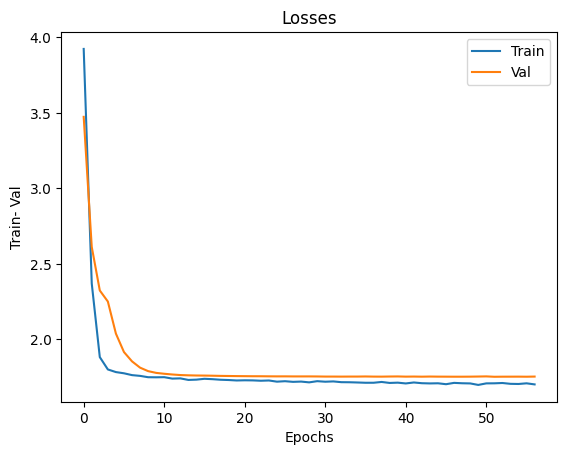

In [28]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')


plt.legend(loc="upper right")
plt.ylabel('Train- Val')
plt.xlabel('Epochs')
plt.title('Losses');

> Without `skills` model is performing good

The reason for this NN behavoiur is simple:

0. Might be skill issue
1. The dataset is small
2. The dataset is agumented, mean random values or users are added in it and there rating

Won't be testing this, will use the surprise library

## More Surprises